In [1]:
from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision.transforms import v2 as transforms
import numpy as np
import wandb
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
generator = torch.Generator().manual_seed(42)
np.random.seed(42)

In [3]:

class GaussianVariational(nn.Module):

    def __init__(self, mu: torch.Tensor, rho: torch.Tensor) -> None:
        super().__init__()

        self.mu = nn.Parameter(mu)
        self.rho = nn.Parameter(rho)

        self.w = None
        self.sigma = None

        self.normal = torch.distributions.Normal(0, 1)

    def sample(self) -> torch.Tensor:
        device = self.mu.device
        epsilon = self.normal.sample(self.mu.size()).to(device)
        self.sigma = torch.log1p(torch.exp(self.rho))
        self.w = self.mu + self.sigma * epsilon

        return self.w

    def log_posterior(self) -> torch.Tensor:
        assert self.w is not None

        log_const = np.log(np.sqrt(2 * np.pi))
        log_exp = ((self.w - self.mu) ** 2) / (2 * self.sigma ** 2)
        log_posterior = -log_const - torch.log(self.sigma) - log_exp

        return log_posterior.sum()


class ScaleMixture(nn.Module):

    def __init__(self, pi: float, sigma1: float, sigma2: float) -> None:
        super().__init__()

        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2

        self.normal1 = torch.distributions.Normal(0, sigma1)
        self.normal2 = torch.distributions.Normal(0, sigma2)

    def log_prior(self, w: torch.Tensor) -> torch.Tensor:
        likelihood_n1 = torch.exp(self.normal1.log_prob(w))
        likelihood_n2 = torch.exp(self.normal2.log_prob(w))

        p_scalemixture = self.pi * likelihood_n1 + (1 - self.pi) * likelihood_n2
        log_prob = torch.log(p_scalemixture).sum()

        return log_prob


class BayesianModule(nn.Module):
    pass


class BayesLinear(BayesianModule):

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 prior_pi: Optional[float] = 0.5,
                 prior_sigma1: Optional[float] = 1.0,
                 prior_sigma2: Optional[float] = 0.0025) -> None:
        super().__init__()

        w_mu = torch.empty(out_features, in_features).uniform_(-0.2, 0.2, generator=generator)
        w_rho = torch.empty(out_features, in_features).uniform_(-5.0, -4.0, generator=generator)

        bias_mu = torch.empty(out_features).uniform_(-0.2, 0.2, generator=generator)
        bias_rho = torch.empty(out_features).uniform_(-5.0, -4.0, generator=generator)

        self.w_posterior = GaussianVariational(w_mu, w_rho)
        self.bias_posterior = GaussianVariational(bias_mu, bias_rho)

        self.w_prior = ScaleMixture(prior_pi, prior_sigma1, prior_sigma2)
        self.bias_prior = ScaleMixture(prior_pi, prior_sigma1, prior_sigma2)

        self.kl_divergence = 0.0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        w = self.w_posterior.sample()
        b = self.bias_posterior.sample()

        w_log_prior = self.w_prior.log_prior(w)
        b_log_prior = self.bias_prior.log_prior(b)

        w_log_posterior = self.w_posterior.log_posterior()
        b_log_posterior = self.bias_posterior.log_posterior()

        total_log_prior = w_log_prior + b_log_prior
        total_log_posterior = w_log_posterior + b_log_posterior
        self.kl_divergence = total_log_posterior - total_log_prior

        return F.linear(x, w, b)


def minibatch_weight(batch_idx: int, num_batches: int) -> float:
    return 2 ** (num_batches - batch_idx) / (2 ** num_batches - batch_idx)


def variational_estimator(nn_class):

    @property
    def kl_divergence(self):
        kl = 0
        for module in self.modules():
            if isinstance(module, BayesianModule):
                kl += module.kl_divergence

        return kl

    setattr(nn_class, "kl_divergence", kl_divergence)

    def sample_elbo(self, inputs, labels, criterion, num_samples, complexity_cost_weight=1):
        loss = 0
        for _ in range(num_samples):
            outputs = self(inputs)
            contr1 = criterion(outputs, labels)
            contr2 = self.kl_divergence * complexity_cost_weight
            # print(f"contr1: {contr1}, contr2: {contr2}")
            loss += contr1 + contr2
        return loss / num_samples

    setattr(nn_class, "sample_elbo", sample_elbo)

    return nn_class

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# MNIST classification

In [5]:
@variational_estimator
class MNISTModel(nn.Module):

    def __init__(self, in_features=28 * 28, out_features=10, prior_sigma_1=0.1, prior_sigma_2=0.4, prior_pi=1):
        super().__init__()

        self.layers = nn.Sequential(
            BayesLinear(
                in_features,
                1200,
                prior_pi,
                prior_sigma_1,
                prior_sigma_2
            ),
            nn.ReLU(),
            BayesLinear(
                1200,
                1200,
                prior_pi,
                prior_sigma_1,
                prior_sigma_2
            ),
            nn.ReLU(),
            BayesLinear(
                1200,
                out_features,
                prior_pi,
                prior_sigma_1,
                prior_sigma_2,
            ),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.layers(x)
        # print(x)
        return x

In [6]:
def train_one_epoch(model, train_loader, optimizer, criterion, num_samples=1):
    model.train()

    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        kl_weight = minibatch_weight(batch_idx, len(train_loader))

        loss = model.sample_elbo(data, target, criterion, num_samples, kl_weight)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()

    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)

            loss = criterion(output, target) + model.kl_divergence * minibatch_weight(batch_idx, len(test_loader))
            total_loss += loss.item()

            preds = torch.argmax(output, 1)
            correct += (preds == target).sum().item()

            # print(f"Predictions: {preds}, Targets: {target}")

    total = len(test_loader.dataset)
    error = (total - correct) / total

    print(f"Correct: {correct}/{total} ({correct / total:.2%})")
    return total_loss / total, error


def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, num_samples, use_wandb=False):
    for epoch in range(num_epochs):
        now = time.time()

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, num_samples)
        val_loss, val_error = evaluate(model, val_loader, criterion)

        elapsed = time.time() - now

        if use_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_error": val_error
            })

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Error: {val_error:.4f}, Time: {elapsed:.2f}s")

In [7]:
def train_mnist(train_loader, val_loader, epochs, lr, num_samples, pi, minus_log_sigma1, minus_log_sigma2, use_wandb=False):
    sigma1 = np.exp(-minus_log_sigma1)
    sigma2 = np.exp(-minus_log_sigma2)

    model = MNISTModel(prior_sigma_1=sigma1, prior_sigma_2=sigma2, prior_pi=pi)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction='sum')

    if use_wandb:
        run = wandb.init(project="asi-paper", name="mnist")

    train(model, train_loader, val_loader, optimizer, criterion, epochs, num_samples, use_wandb=use_wandb)

    if use_wandb:
        run.finish()

    return model

In [8]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(28 * 28)),
])


mnist_dataset = datasets.MNIST(
    root="./mnist",
    download=True,
    transform=transform,
    train=True
)
# transformed_data = transform(mnist_dataset.data).to(device)
# y = mnist_dataset.targets.to(device)
# mnist_dataset = torch.utils.data.TensorDataset(transformed_data, y)


train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, [50_000, 10_000], generator=generator)

kwargs = {
    'batch_size': batch_size,
    'num_workers': 2,
    'generator': generator,
}

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    **kwargs
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    **kwargs
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.90MB/s]


## Grid search with wandb
Uncomment the code below to run a grid search and log the results to wandb.

In [9]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret('wand-api-key-asi')

# wandb.login(key=key)


# def train_wrapper():
#     with wandb.init(project="asi-paper") as run:
#         model = train_mnist(
#             train_loader,
#             val_loader,
#             epochs=10,
#             lr=run.config.lr,
#             num_samples=run.config.sample_nbr,
#             pi=run.config.pi,
#             minus_log_sigma1=run.config.min_log_sigma1,
#             minus_log_sigma2=run.config.min_log_sigma2,
#             use_wandb=True
#         )

#     return model


# sweep_configuration = {
#     "method": "grid",
#     "metric": {"goal": "minimize", "name": "val_error"},
#     'name': "sweep-mnist",
#     "parameters": {
#         "lr": {'values': [1e-3, 1e-4, 1e-5]},
#         "sample_nbr": {'values': [1, 2, 5, 10]},
#         "pi": {'values': [0.25, 0.5, 0.75]},
#         "min_log_sigma1": {'values': [0, 1, 2]},
#         "min_log_sigma2": {'values': [6, 7, 8]},
#     },
# }

# sweep_id = wandb.sweep(sweep=sweep_configuration, project="asi-paper")
# wandb.agent(sweep_id, function=train_wrapper)

## Manual training
Uncomment the code below to train the model with specified hyperparameters and save the model checkpoint.

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret('wand-api-key-asi')

wandb.login(key=key)

model = train_mnist(train_loader, val_loader, epochs=200, lr=1e-3, num_samples=1, pi=0.75, minus_log_sigma1=1, minus_log_sigma2=7, use_wandb=True)
torch.save(model.state_dict(), "mnist_model.pt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: matteo-ghia (matteo-ghia-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250518_091425-zw8pab3i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mnist
wandb: ⭐️ View project at https://wandb.ai/matteo-ghia-politecnico-di-torino/asi-paper
wandb: 🚀 View run at https://wandb.ai/matteo-ghia-politecnico-di-torino/asi-paper/runs/zw8pab3i


Correct: 3935/10000 (39.35%)
Epoch 1/200, Train Loss: 40590.1335, Val Loss: 1562.2227, Val Error: 0.6065, Time: 20.85s
Correct: 3933/10000 (39.33%)
Epoch 2/200, Train Loss: 40116.6575, Val Loss: 1537.9647, Val Error: 0.6067, Time: 21.16s
Correct: 3967/10000 (39.67%)
Epoch 3/200, Train Loss: 39501.4753, Val Loss: 1515.9650, Val Error: 0.6033, Time: 21.74s
Correct: 4005/10000 (40.05%)
Epoch 4/200, Train Loss: 38928.8287, Val Loss: 1496.0475, Val Error: 0.5995, Time: 21.40s
Correct: 4779/10000 (47.79%)
Epoch 5/200, Train Loss: 38415.9278, Val Loss: 1476.8729, Val Error: 0.5221, Time: 21.14s
Correct: 7529/10000 (75.29%)
Epoch 6/200, Train Loss: 37913.8220, Val Loss: 1458.9339, Val Error: 0.2471, Time: 21.43s
Correct: 9464/10000 (94.64%)
Epoch 7/200, Train Loss: 37443.7179, Val Loss: 1444.0805, Val Error: 0.0536, Time: 21.21s
Correct: 9617/10000 (96.17%)
Epoch 8/200, Train Loss: 37044.2600, Val Loss: 1431.5220, Val Error: 0.0383, Time: 20.98s
Correct: 9632/10000 (96.32%)
Epoch 9/200, Train 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch ▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██████
wandb: train_loss ███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
wandb:  val_error █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
wandb:   val_loss █▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      epoch 199
wandb: train_loss 7815.99614
wandb:  val_error 0.1184
wandb:   val_loss 296.01129
wandb: 
wandb: 🚀 View run mnist at: https://wandb.ai/matteo-ghia-politecnico-di-torino/asi-paper/runs/zw8pab3i
wandb: ⭐️ View project at: https://wandb.ai/matteo-ghia-politecnico-di-torino/asi-paper
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250518_091425-zw8pab3i/logs


In [11]:
# model = MNISTModel(prior_sigma_1=np.exp(-1), prior_sigma_2=np.exp(-7), prior_pi=0.75)
# model.to(device)
# model.load_state_dict(torch.load("mnist_model.pt"))

# Regression curves

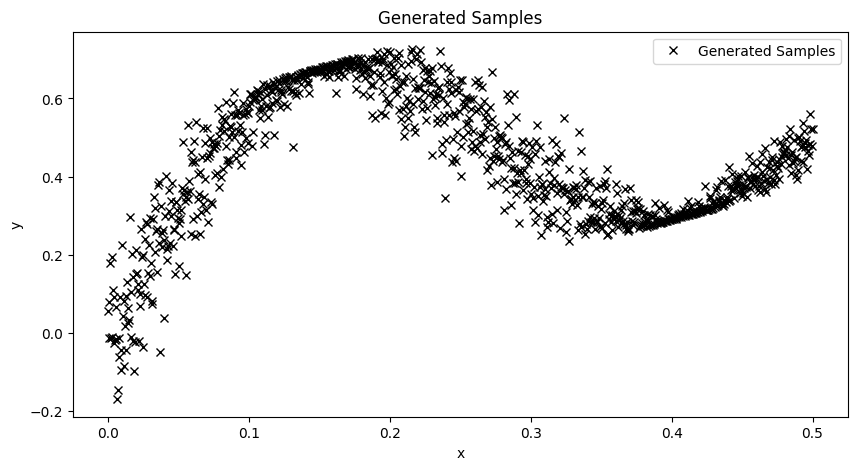

In [12]:
def generate_samples(num_samples):
    eps = np.random.normal(0, 0.02, num_samples)
    x = np.linspace(0, 0.5, num_samples)
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps))
    return x, y


def save_samples(x, y, filename):
    df = pd.DataFrame({'x': x, 'y': y})
    df.to_csv(filename, index=False)


def load_samples(filename):
    df = pd.read_csv(filename)
    x = df['x'].values
    y = df['y'].values
    return x, y


def plot_samples(x, y):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'kx', label='Generated Samples')
    plt.title('Generated Samples')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()


x, y = generate_samples(1000)
save_samples(x, y, 'regression_samples.csv')


x, y = load_samples('regression_samples.csv')
plot_samples(x, y)

X_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

train_dataset = torch.utils.data.TensorDataset(X_tensor[:800], y_tensor[:800])
val_dataset = torch.utils.data.TensorDataset(X_tensor[800:], y_tensor[800:])


kwargs = {
    'batch_size': batch_size,
    'generator': generator,
}

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    **kwargs
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    **kwargs
)

In [13]:
@variational_estimator
class RegressionModel(nn.Module):
    def __init__(self, in_features=1, out_features=1, prior_sigma_1=0.1, prior_sigma_2=0.4, prior_pi=1):
        super().__init__()

        self.layers = nn.Sequential(
            BayesLinear(
                in_features,
                200,
                prior_pi,
                prior_sigma_1,
                prior_sigma_2
            ),
            nn.ReLU(),
            BayesLinear(
                200,
                200,
                prior_pi,
                prior_sigma_1,
                prior_sigma_2
            ),
            nn.ReLU(),
            BayesLinear(
                200,
                out_features,
                prior_pi,
                prior_sigma_1,
                prior_sigma_2,
            ),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [14]:
def evaluate_regression(regressor, X, y, samples=100, std_multiplier=2):
    preds = [regressor(X) for _ in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ci_acc = (ci_lower <= y) * (ci_upper >= y)
    ci_acc = ci_acc.float().mean()
    return ci_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()


def train_regression(model, train_loader, val_loader, optimizer, criterion, num_epochs, num_samples, use_wandb=False):
    for epoch in range(num_epochs):
        now = time.time()

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, num_samples)
        ci_acc, ci_upper, ci_lower = evaluate_regression(model, val_loader.dataset.tensors[0], val_loader.dataset.tensors[1])

        elapsed = time.time() - now

        if use_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "ci_acc": ci_acc,
                "ci_upper": ci_upper,
                "ci_lower": ci_lower,
            })

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, CI acc: {ci_acc}, CI upper acc: {ci_upper}, CI lower acc: {ci_lower} Time: {elapsed:.2f}s")

In [15]:
def train_regression_model(train_loader, val_loader, epochs, lr, num_samples, pi, minus_log_sigma1, minus_log_sigma2, use_wandb=False):
    sigma1 = np.exp(-minus_log_sigma1)
    sigma2 = np.exp(-minus_log_sigma2)

    model = RegressionModel(1, 1, prior_sigma_1=sigma1, prior_sigma_2=sigma2, prior_pi=pi)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # if use_wandb:
    #     run = wandb.init(project="asi-paper", name="regression")

    train_regression(model, train_loader, val_loader, optimizer, criterion, epochs, num_samples, use_wandb=use_wandb)

    # if use_wandb:
    #     run.finish()

    return model

In [16]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret('wand-api-key-asi')

# wandb.login(key=key)


# def train_wrapper():
#     with wandb.init(project="asi-paper") as run:
#         model = train_regression_model(
#             train_loader,
#             val_loader,
#             epochs=15,
#             lr=run.config.lr,
#             num_samples=run.config.sample_nbr,
#             pi=run.config.pi,
#             minus_log_sigma1=run.config.min_log_sigma1,
#             minus_log_sigma2=run.config.min_log_sigma2,
#             use_wandb=True
#         )

#     return model


# sweep_configuration = {
#     "method": "bayes",
#     "metric": {"goal": "maximize", "name": "ci_acc"},
#     'name': "sweep-regression",
#     "parameters": {
#         "lr": {'min': 1e-5, 'max': 1e-2},
#         "sample_nbr": {'min': 1, 'max': 10},
#         "pi": {'min': 0.25, 'max': 0.75},
#         "min_log_sigma1": {'min': 0, 'max': 2},
#         "min_log_sigma2": {'min': 6, 'max': 8},
#     },
# }

# sweep_id = wandb.sweep(sweep=sweep_configuration, project="asi-paper")
# wandb.agent(sweep_id, function=train_wrapper)

In [17]:
# model = train_regression_model(train_loader, val_loader, epochs=10, lr=1e-3, num_samples=1, pi=0.5, minus_log_sigma1=0, minus_log_sigma2=6)

In [18]:
# model.eval()
# predicted = model(X_tensor).cpu().detach().numpy()

# plt.figure(figsize=(10, 5))
# plt.plot(x, y, 'kx', label='Generated Samples')
# plt.plot(x, predicted, 'r-', label='Predicted Mean')
# # plt.fill_between(x, predicted - 2 * np.std(predicted), predicted + 2 * np.std(predicted), color='r', alpha=0.2, label='Uncertainty')
# plt.title('Regression with Uncertainty')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()